In [4]:
import dca_frustratometer
import pandas as pd
import numpy as np
import seaborn as sns



In [13]:
mutations = experimental_ddG={"16_A": 2.14, "18_A": 3.52, "21_S": 0.05, "25_A": 2.41, "27_V": 1.58, "29_A": 3.23, "30_S": 0.23,
                              "33_A":-0.21, "33_G": 0.10, "35_S": 0.10, "35_G":-0.31, "42_V": 0.72, "44_A": 3.66, "46_G": 0.88,
                              "47_V": 0.11, "52_G": 2.22, "53_G": 2.39, "59_V": 1.08, "65_A": 4.01, "66_A": 2.34, "68_A": 2.17,
                              "73_A": 3.07, "79_A":-0.67, "79_G": 1.21, "81_G": 1.86, "83_A": 0.82, "83_G": 1.28, "85_A": 4.20,
                              "92_A": 1.56, "94_A": 4.50, "96_A": 3.36}

seq_map={7: 1,  8: 2, 9: 3, 10: 4, 11: 5, 12: 7, 13: 8, 14: 9, 15: 10, 16: 11, 17: 12, 18: 13,
         19: 14, 20: 15, 21: 16, 22: 17, 23: 18,24: 19, 25: 20, 26: 21, 27: 22, 30: 23, 31: 24,
         32: 25, 33: 26, 34: 27, 35: 28, 36: 29, 37: 30, 38: 31, 39: 32, 40: 33, 41: 34, 42: 35,
         43: 36, 44: 37, 45: 38, 46: 39, 47: 40, 48: 41, 50: 42, 51: 43, 52: 44, 53: 45, 54: 46,
         55: 47, 56: 48, 57: 49, 58: 50, 59: 51, 60: 52, 61: 53, 62: 54, 63: 55, 64: 56, 65: 57,
         66: 58, 67: 59, 68: 60, 69: 61, 70: 62, 71: 63, 72: 64, 73: 65, 74: 66, 75: 67, 76: 68,
         77: 69, 78: 70, 79: 71, 80: 72, 81: 73, 82: 74, 83: 75, 84: 76, 85: 77, 86: 78, 87: 79}

structure = 'examples/data/1gm1.pdb'

awsem_model = dca_frustratometer.AWSEMFrustratometer(structure,'A')
sequence=dca_frustratometer.pdb.get_sequence(structure,'A')
dca_model = dca_frustratometer.PottsModel.from_potts_model_file('examples/data/PDZ_PFAM_27_dca_gap_threshold_0.2.mat', structure, 'A', 
                                                                sequence_cutoff=1, distance_cutoff=16, distance_matrix_method='CB')
dca_model.potts_model['h']=dca_model.potts_model['h'].T
dca_model.potts_model['J']=dca_model.potts_model['familycouplings'].reshape(81,21,81,21).transpose(0,2,1,3)
original_mask = dca_model.mask
indices=[i-1 for i in seq_map.keys()]
mask = dca_model.mask[indices][:,indices].copy()
#dca_model.potts_model['h'][0]=0
#dca_model.potts_model['h'][6]=0
#dca_model.potts_model['h'][80]=0
mask = np.concatenate([[[False]*78],mask[:5],[[False]*78],mask[5:],[[False]*78]]).T
mask = np.concatenate([[[False]*81],mask[:5],[[False]*81],mask[5:],[[False]*81]]).T
dca_model.mask = mask

@> 1393 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 1393 atoms and 1 coordinate set(s) were parsed in 0.01s.


<AxesSubplot:>

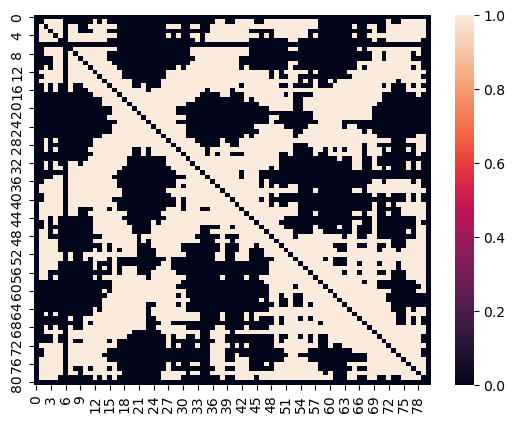

In [14]:
sns.heatmap(mask)

In [15]:
Hana_data=pd.read_csv('/home/cb/Documents/Hana/1GM1_ddAWSEM_ddDCA_ddG_Values.txt',index_col=0)
#Hana_data

In [16]:
def map_sequence(seq,n=81):
    new_seq=''
    seq_split=[aa for aa in seq]
    t=0
    for i,j in seq_map.items():
        while j>t:
            new_seq+='-'
            t+=1
        new_seq+=seq_split[i]
        t+=1
    while t<n:
        new_seq+='-'
        t+=1
    return new_seq

new_seq=map_sequence(awsem_model.sequence)
print(len(new_seq),new_seq)



81 -VELAK-TDGSLGISVTGGVNTSHGGIYVKAIIPKGAAESDGIHKGDRVLAVNGVSLEGATHKQAVETLRNTGQVVHLLL-


In [17]:
data=[]
native_seq=awsem_model.sequence
awsem_native=awsem_model.native_energy(native_seq) / 4.184
dca_native=dca_model.native_energy(map_sequence(native_seq))
for mutation, experimental_energy in mutations.items():
    pos, aa = mutation.split('_')
    pos=int(pos)-9
    seq = str(awsem_model.sequence)
    new_seq = ''.join([(a if i!=pos else aa ) for i, a in enumerate(seq)])
    assert len(new_seq)==len(seq)
    assert new_seq != seq
    awsem_energy = awsem_model.native_energy(new_seq) / 4.184 #kcal/mol
    dca_energy = dca_model.native_energy(map_sequence(new_seq)) #kcal/mol/K
    data+=[[mutation, experimental_energy, awsem_energy - awsem_native, dca_energy-dca_native]]
data = pd.DataFrame(data, columns=['mutation','experimental','AWSEM','DCA'])
data
#data.to_csv('AWSEM_DCA_1GM1.csv')



,mutation,experimental,AWSEM,DCA
0,16_A,2.14,1.315032,11.800684
1,18_A,3.52,1.445230,10.673638
2,21_S,0.05,0.057403,-1.093766
3,25_A,2.41,2.965892,12.034131
4,27_V,1.58,0.677430,4.426616
5,29_A,3.23,2.642152,9.454077
6,30_S,0.23,0.029754,7.325702
7,33_A,-0.21,0.408958,5.537648
8,33_G,0.10,0.117649,7.792780
9,35_S,0.10,0.062834,2.004856


In [18]:
dca_model.native_energy(map_sequence(native_seq))

-387.8374716276195

/tmp/ipykernel_85355/331720583.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  slope = np.linalg.lstsq(x[:,np.newaxis],y)[0][0]
/tmp/ipykernel_85355/331720583.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope = np.linalg.lstsq(x[:,np.newaxis],y)[0][0]


(-1.0, 6.0)

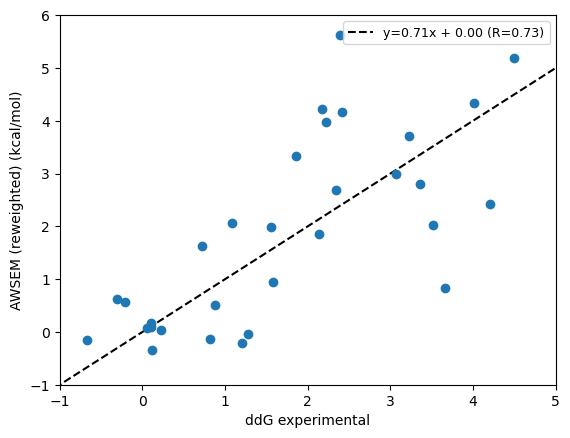

In [19]:
import matplotlib.pyplot as plt
from statistics import linear_regression
#plt.scatter(data['experimental'],data['DCA'])
x = data['experimental']
y = data['AWSEM']

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
slope = np.linalg.lstsq(x[:,np.newaxis],y)[0][0]
intercept = 0
xl=np.array([-2,8])
line = slope*xl+intercept
r_value=np.corrcoef(x,y)[0,1]
plt.plot(xl, line/slope, '--k', label='y={:.2f}x + {:.2f} (R={:.2f})'.format(slope,intercept,r_value))
plt.plot(x,y/slope, 'o') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.legend(fontsize=9)
plt.xlabel('ddG experimental')
plt.ylabel('AWSEM (reweighted) (kcal/mol)')
plt.xlim(-1, 5)
plt.ylim(-1, 6)

/tmp/ipykernel_85355/689686596.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  slope = np.linalg.lstsq(x[:,np.newaxis],y)[0][0]
/tmp/ipykernel_85355/689686596.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope = np.linalg.lstsq(x[:,np.newaxis],y)[0][0]


(-5.0, 22.0)

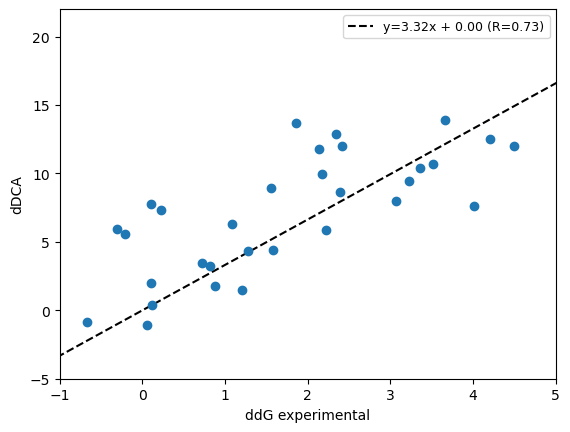

In [20]:
import matplotlib.pyplot as plt
from statistics import linear_regression
#plt.scatter(data['experimental'],data['DCA'])
x = data['experimental']
y = data['DCA']

coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 
slope = np.linalg.lstsq(x[:,np.newaxis],y)[0][0]
intercept = 0
xl=np.array([-2,8])
line = slope*xl+intercept
r_value=np.corrcoef(x,y)[0,1]
plt.plot(xl, line, '--k', label='y={:.2f}x + {:.2f} (R={:.2f})'.format(slope,intercept,r_value))
plt.plot(x,y, 'o') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.legend(fontsize=9)
plt.xlabel('ddG experimental')
plt.ylabel('dDCA')
plt.xlim(-1, 5)
plt.ylim(-5, 22)

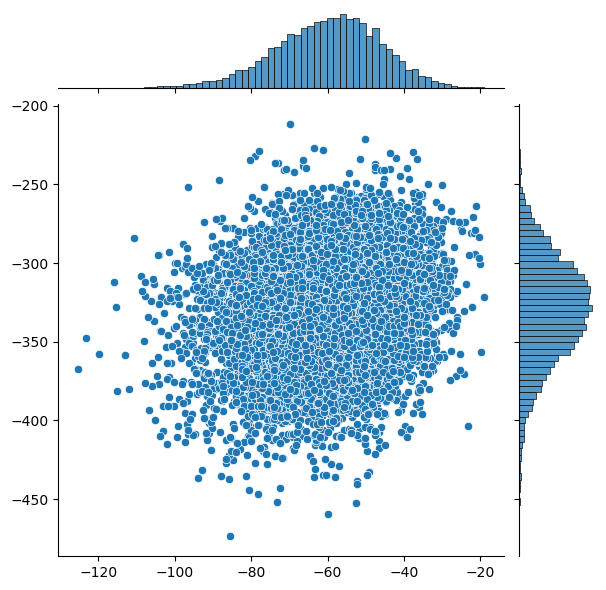

In [55]:
#Generate shufled sequences
import random

dca_energies=[]
awsem_energies=[]
for i in range(10000):
    s=[a for a in native_seq]
    random.shuffle(s)
    seqs+=[''.join(s)]
    dca_energies+=[dca_model.native_energy(map_sequence(s))]
    awsem_energies+=[awsem_model.native_energy(s)]

sns.jointplot(x=dca_energies,y=awsem_energies)



